# Prise en main d'Atom

In [1]:
from atom import *
import numpy as np
import random
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (15,10)

## Tutoriel

Pour créer un marché, il suffit de faire `Market(assets)`, où `assets` est la liste des assets du marché. De base, il existe deux types d'agents :
* Des dumb agents, qui n'envoient aucun ordres hormis ceux qu'on leur demande d'envoyer
* Des ZIT, qui envoient, à chaque fois qu'ils ont la parole, un ordre aléatoire

Pour créer ces agents, le marché doit leur être passé en paramètre. Ensuite, la méthode `add_trader` du marché permet de rajouter notre agent au marché.

### Dumb Agents

Un dumb agent n'est qu'un intermédiaire entre nous et le marché pour qu'on puisse envoyer l'ordre que l'on souhaite. Pour ce faire, on utilise la méthode `send_order` de l'agent, qui prend en paramètres un ordre et le marché.

Le premier type d'ordre est les limit orders, que l'on créé avec la commande `LimitOrder(asset, source, direction, price, qty)`.

In [2]:
m = Market(['Apple', 'Google']) # Créé un marché dont les assets sont 'Apple' et 'Google'
t = DumbAgent(m) # Créé un dumb agent
m.add_trader(t) # Rajoute le dumb agent au marché

t.send_order(LimitOrder('Apple', t, 'ASK', 5000, 10), m)
# Le dumb agent a envoyé au marché un ordre de vente de 10 actions Apple au prix 5000
t.send_order(LimitOrder('Apple', t, 'BID', 6000, 5), m)
# Le dumb agent a envoyé au marché un ordre d'achat de 5 actions Apple au prix 6000

# LimitOrder;asset;agent;direction;price;qty
# CancelMyOrders;asset;agent
# Tick;nb_tick
# or Tick;nb_tick;asset;last_price
# Price;asset;bider;asker;price;qty;timestamp(µs)
# NewAgent;name;cash;asset 1:qty 1,...,asset n:qty n
# Agent;name;cash;last_modified_asset;qty
# AgentWealth;agent;wealth;timestamp(µs)

NewAgent;Dumby 1;0;Apple:0,Google:0
AgentWealth;Dumby 1;0;506
LimitOrder;Apple;Dumby 1;ASK;5000;10
LimitOrder;Apple;Dumby 1;BID;6000;5
Price;Apple;Dumby 1;Dumby 1;5000;5;1020
Agent;Dumby 1;0;Apple;0;1063
AgentWealth;Dumby 1;0;1104


### Trace

On remarque qu'en sortie, on obtient la trace de toutes les opérations effectuées. Les premières lignes (commençant par '#') de cette trace précisent la syntaxe utilisée.
* Les lignes LimitOrder et CancelMyOrders sont affichées quand un ordre (LimitOrder ou CancelMyOrders) a été envoyé
* Les lignes Tick correspondent à une fin de tick
* Les lignes Price sont affichées quand un prix est fixé (long fixing)
* Les lignes NewAgent sont affichées quand un agent est rajouté au marché
* Les lignes Agent sont affichées quand un agent a son cash ou sa quantité d'actions qui sont modifées
* Les lignes AgentWealth correspondent au wealth des agents

On peut afficer cette trace à différents endroit, à l'aide du paramètre `out` quand on créé le marché :
* Si rien n'est précisé, la trace est affichée dans la console
* Si `out = None`, rien n'est affiché
* Si `out = FileObject`, la trace est affichée dans un fichier. Si on utilise cette méthode, il est impératif de penser à fermer le fichier après qu'on ait fini d'écrire dedans.

In [3]:
file = open('trace.dat', 'w') # On ouvre le fichier trace.dat en écriture

m = Market(['Apple'], out=file) # On donne ce fichier au marché
t = DumbAgent(m)
m.add_trader(t)
t.send_order(LimitOrder('Apple', t, 'ASK', 5000, 10), m)

file.close() # On n'oublie pas de fermer le fichier.

Le marché a également un paramètre `print_orderbooks`, qui vaut `False` lorsque rien n'est précisé. Quand ce paramètre vaut `True`, les orderbooks sont affichés à chaque fois qu'ils sont modifiés.

En outre, on dispose d'une méthode `print_state()` sur le marché, qui affiche le nombre d'ordres reçus, le nombre de prix fixés et le nombre d'ordres ASK et BID en attente.

In [4]:
file = open('trace.dat', 'w') # On ouvre le fichier trace.dat en écriture

m = Market(['Apple'], out=file, print_orderbooks=True)
t = DumbAgent(m)
m.add_trader(t)
t.send_order(LimitOrder('Apple', t, 'ASK', 5000, 10), m)
t.send_order(LimitOrder('Apple', t, 'BID', 6000, 5), m)
m.print_state()

file.close()

Regarder le fichier trace.dat. Il contient la trace, dans laquelle sont aussi affichés les orderbooks dès qu'ils sont modifiés (après avoir reçu un prix, ou après avoir fixé un prix).

### ZITs

Les ZITs peuvent être créés de la même façon que les dumb agents, en utilisant la commande `ZITTrader(m)`. Une fois les ZITs créés et ajoutés au marché, on peut utiliser la méthode du marché `run_once()`, qui donne la parole à chaque agent sur chaque asset.

In [5]:
m = Market(['Apple'])
m.add_trader(ZITTrader(m))
m.add_trader(ZITTrader(m))
m.run_once()

# LimitOrder;asset;agent;direction;price;qty
# CancelMyOrders;asset;agent
# Tick;nb_tick
# or Tick;nb_tick;asset;last_price
# Price;asset;bider;asker;price;qty;timestamp(µs)
# NewAgent;name;cash;asset 1:qty 1,...,asset n:qty n
# Agent;name;cash;last_modified_asset;qty
# AgentWealth;agent;wealth;timestamp(µs)

NewAgent;ZIT 10;0;Apple:0
AgentWealth;ZIT 10;0;1626
NewAgent;ZIT 11;0;Apple:0
AgentWealth;ZIT 11;0;2035
LimitOrder;Apple;ZIT 11;ASK;7765;1
LimitOrder;Apple;ZIT 10;ASK;6989;8
Tick;1


On peut aussi utiliser la méthode du maché `generate(nb_ZIT, nb_turn)`, qui créé nb_ZIT ZITS, les ajoute au marché et fait nb_turn tours de parole. Le code précédent est donc équivalent au code suivant :

In [6]:
m = Market(['Apple'])
m.generate(2, 1)

# LimitOrder;asset;agent;direction;price;qty
# CancelMyOrders;asset;agent
# Tick;nb_tick
# or Tick;nb_tick;asset;last_price
# Price;asset;bider;asker;price;qty;timestamp(µs)
# NewAgent;name;cash;asset 1:qty 1,...,asset n:qty n
# Agent;name;cash;last_modified_asset;qty
# AgentWealth;agent;wealth;timestamp(µs)

NewAgent;ZIT 12;0;Apple:0
AgentWealth;ZIT 12;0;1264
NewAgent;ZIT 13;0;Apple:0
AgentWealth;ZIT 13;0;1398
LimitOrder;Apple;ZIT 13;BID;5767;7
LimitOrder;Apple;ZIT 12;BID;4765;4
Tick;1


### Pour aller plus loin...

Finalement, tous les agents ont deux paramètres facultatifs :
* `initial_assets`, qui est une liste de même taille que la liste des assets du marché, et qui contient l'ensemble des assets dont disposent les agents. Si rien n'est précisé, on suppose que c'est une liste remplie de zéros.
* `cash`, qui est le cash initial dont dispose l'agent et qui vaut 0 si rien n'est précisé.

Par exemple, si `m = Market(['Apple', 'Google'])`, alors la commande `m.add_trader(ZITTrader(m, [5, 10], 5000))` rajoute au marché un ZIT qui dispose initialement d'un cash de 5000, de 5 actions d'Apple et de 10 actions de Google.

La méthode `generate` dispose elle de deux paramètres `init_assets` et `init_cash`, qui sont tous deux des entiers. Chaque ZIT est alors créé avec un cash initial égal à `init_cash` et disposant, pour chaque asset, de `init_assets` actions.

In [9]:
m = Market(['Apple', 'Google'])
m.generate(2, 3, 10, 10000)
m.print_state()
# Créé 2 ZIT, qui vont faire 3 tours de parole
# et qui ont initialement 10000 de cash, 10 actions Apple et 10 actions Google.

# LimitOrder;asset;agent;direction;price;qty
# CancelMyOrders;asset;agent
# Tick;nb_tick
# or Tick;nb_tick;asset;last_price
# Price;asset;bider;asker;price;qty;timestamp(µs)
# NewAgent;name;cash;asset 1:qty 1,...,asset n:qty n
# Agent;name;cash;last_modified_asset;qty
# AgentWealth;agent;wealth;timestamp(µs)

NewAgent;ZIT 18;10000;Apple:10,Google:10
AgentWealth;ZIT 18;10000;2214
NewAgent;ZIT 19;10000;Apple:10,Google:10
AgentWealth;ZIT 19;10000;2351
LimitOrder;Apple;ZIT 18;ASK;4907;4
LimitOrder;Google;ZIT 18;ASK;3189;8
LimitOrder;Apple;ZIT 19;ASK;7126;5
LimitOrder;Google;ZIT 19;ASK;8343;8
Tick;1
LimitOrder;Apple;ZIT 18;BID;1906;5
LimitOrder;Google;ZIT 18;BID;3591;3
Price;Google;ZIT 18;ZIT 18;3189;3;3125
Agent;ZIT 18;10000;Google;10;3169
AgentWealth;ZIT 18;41890;3211
LimitOrder;Apple;ZIT 19;ASK;8176;4
LimitOrder;Google;ZIT 19;BID;8197;9
Price;Google;ZIT 19;ZIT 18;3189;5;3476
Agent;ZIT 18;25945;Google;5;3522
AgentWealth;ZIT 18;41890;3566
Agent;ZIT 19;-5945;Google;15;3637
AgentWealth;ZIT 1

## Utilisation de la trace pour afficher différentes courbes

In [17]:
file = open('trace.dat', 'w')

m = Market(['Apple', 'Google'], out=file)
m.generate(3, 100, 10, 0)
m.print_state()

file.close()

### Affichage des prix

On peut extraire les prix de la trace à l'aide de la fonction `extract_prices`, qui prend en entrée un nom de fichier, et retourne un dictionnaire dont les clés sont les assets et les valeurs sont des tuples (T, P), avec T la liste des timestamps et P la liste des prix correspondants (pour un asset donné).

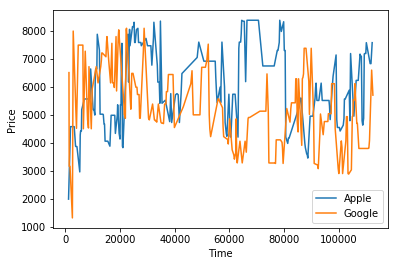

In [13]:
Prices = extract_prices('trace.dat')
for asset in Prices.keys():
    plt.plot(Prices[asset][0], Prices[asset][1], '-', label=asset)
plt.legend(loc='best')
plt.xlabel('Time')
plt.ylabel('Price')
plt.show()

### Affichage de l'évolution du wealth des agents

À la fin d'une simulation, on peut accéder au wealth d'un agent avec la méthode `get_wealth` (qui prend le marché en paramètre). Par exemple, on peut afficher les caractéristiques (avec la méthode `get_infos`) de l'agent le plus riche et du plus pauvre:

In [15]:
t_max = m.traders[0]
t_min = m.traders[0]
for t in m.traders: # On parcourt l'ensemble des traders
    if t.get_wealth(m) > t_max.get_wealth(m):
        t_max = t
    elif t.get_wealth(m) < t_max.get_wealth(m):
        t_min = t
print("Agent le plus riche - "+t_max.get_infos(m))
print("Agent le plus pauvre - "+t_min.get_infos(m))

Agent le plus riche - ZIT 24:
Cash: -27355
Apple: 30
Google: 6
Wealth: 234353

Agent le plus pauvre - ZIT 23:
Cash: 747649
Apple: -97
Google: -10
Wealth: -44885



On peut aussi afficher l'évolution du wealth de tous les agents, en lisant la trace : la fonction `extract_wealths` prend un nom de fichier en entrée et retourne un dictionnaire dont les clés sont les agents et les valeurs sont des listes (T, W) où T est la liste des timestamps et W la liste des wealths de cet agent.

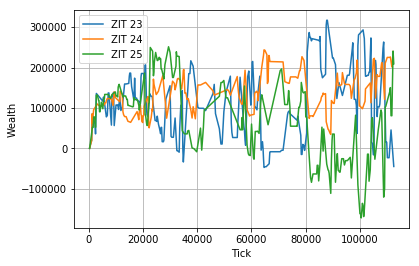

In [16]:
Wealth = extract_wealths('trace.dat')
for agent in Wealth.keys():
    T, W = Wealth[agent]
    plt.plot(T, W, '-', label=agent)
plt.legend(loc='best')
plt.grid()
plt.xlabel('Tick')
plt.ylabel('Wealth')
plt.show()

### Bien-être social 

On peut aussi afficher l'évolution du bien-être social selon le tick. On dispose de deux fonctions pour récupérer depuis la trace :
* `process_social_welfare(filename, welfare_type)` avec welfare_type valant 'utilitarian', 'min' ou 'max' et qui retourne un tuple (Tick, Welfare)
* `process_all_social_welfare(filename)` qui retourne un tuple (Tick, Welfare) où Welfare est un dictionnaire dont les clés sont 'utilitarian', 'min' et 'max' et les valeurs sont les listes des valeurs prises par les différents bien-êtres sociaux. Pour pouvoir comparer ces différents welfares, les valeurs sont normalisées pour être comprises entre 0 et 1.

In [ ]:
out = open('trace.dat', 'w')
m = Market(out)
m.generate(['Apple', 'Google'], 5, 100, init_assets=10)
# la méthode generate a un paramètre facultatif :
# init_assets, qui est le nombre initial d'assets dont disposent les agents
out.close()

In [ ]:
Tick, Welfare = process_all_social_welfare('trace.dat')
for welfare_type in Welfare.keys():
    plt.plot(Tick, Welfare[welfare_type], '-', label=welfare_type+' social welfare')
plt.legend(loc='best')
plt.xlabel('Tick')
plt.ylabel('Welfare')
plt.show()

### Affichage des rentabilités

On peut aussi afficher la séquence des rentabilités en utilisant numpy : si $p_n$ est le $n$-ème élément de Prices, alors
> (Prices[1:]-Prices[:-1])/Prices[:-1] (resp. np.log(Prices[1:]) - np.log(Prices[:-1]))

donne la séquence des $\dfrac{p_{n+1}-p_n}{p_n}$ (resp. $\ln(p_{n+1})-\ln(p_n)$).

In [ ]:
Prices = np.array(process_prices('trace.dat', asset))
Returns = (Prices[1:]-Prices[:-1])/Prices[:-1]
Returns_eco = np.log(Prices[1:]) - np.log(Prices[:-1])
plt.plot(Returns, '-', label="Returns (growth rate)")
plt.plot(Returns_eco, '-', label="Returns (log difference)")
plt.axhline(0, color='k')
plt.ylabel('Return ('+asset+')')
plt.legend(loc='best')
plt.show()

In [ ]:
# Pour la suite, pour avoir de jolies courbes, mieux vaut avoir beaucoup de points...
out = open('trace.dat', 'w')
m = Market(out)
m.generate(['Apple'], 10, 10000)
out.close()

Ou alors, on peut affichier l'histogramme des rentabilités (définies comme la différence logarithmique) :

In [ ]:
asset = 'Apple'
R, D, N = process_returns_hist('trace.dat', asset, 100)
# process_returns_hist prend un fichier, un asset et un nombre de points, et retourne un triplet (R, D, N) avec
# R les rentabilités (définies comme la différence logarithmique), D leur densité
# et N leur densité si la distribution de ces rentabilités suivait une loi normale de même espérance et écart-type.
plt.semilogy(R, D, 'o', label='Returns ('+asset+')')
plt.semilogy(R, N, '--', label='Normal PDF')
plt.xlabel('Returns')
plt.legend(loc='best')
plt.axis([min(R)*1.04, max(R)*1.04, 10**-5, max(D)*1.1])
plt.show()

On observe bien le fait stylisé associé à la rentabilité : par rapport à une gaussienne de même espérance et même écart type, on a une forte kurtosis (pic central de plus grande amplitude) et des queues plus épaisses.

### Histogramme des rentabilité quand les prix sont fixés aléatoirement

Le but de cette partie est de montrer que le fait stylisé qu'on obtient avec un marché financier à carnet d'ordres asynchrone ne peut être obtenu avec des prix fixés aléatoirement.
On va générer une fausse trace dans laquelle des prix (500000) sont fixés aléatoirement uniformément entre 1 et 100.

In [ ]:
out = open('fake_trace.dat', 'w')
for i in range(500000):
    out.write("Price;Apple;ZIT 0;ZIT 0;"+str(random.randint(1, 100))+";1\n")
out.close()

On va alors afficher l'histogramme des rentabilités.

In [ ]:
R, D, N = process_returns_hist('fake_trace.dat', 'Apple', 50)
# process_returns_hist prend un fichier, un asset et un nombre de points, et retourne un triplet (R, D, N) avec
# R les rentabilités (définies comme la différence logarithmique), D leur densité
# et N leur densité si la distribution de ces rentabilités suivait une loi normale de même espérance et écart-type.
plt.semilogy(R, D, 'o', label='Fake returns')
plt.semilogy(R, N, '--', label='Normal PDF')
plt.xlabel('Returns')
plt.legend(loc='best')
plt.axis([min(R)*1.04, max(R)*1.04, 4*10**-3, max(D)*1.1])
plt.show()

On n'observe plus une sorte de gausienne avec un gros pic et des queues épaisses, mais deux demi-droites.

### Avec des vraies données... (Cours du bitcoin en dollar)

In [ ]:
R, D, N = process_returns_hist('BTCUSD.dat', 'BTCUSD', 100)
# BTCUSD.dat : cours de BTCUSD (chaque heure) 
plt.semilogy(R, D, 'o', label='Returns (BTCUSD)')
plt.semilogy(R, N, '--', label='Normal PDF')
plt.xlabel('Returns')
plt.legend(loc='best')
plt.axis([min(R)*1.04, max(R)*1.04, 3*10**-2, max(D)*1.2])
plt.show()

## Utilisation de replay

On peut passer au marché un fichier d'ordres et d'agents (les lignes "NewAgent" et "*Order" de la trace - seules ces lignes sont lues), et la méthode replay va rejouer l'ensemble des opérations effectuées.

In [ ]:
m = Market()
m.replay('orderFileEx1.dat')
m.print_state()

On peut aussi afficher la séquence des prix en précisant un fichier de sortie.

In [ ]:
out = open('orderFileEx1output.dat', 'w')
m = Market(out)
m.add_asset(OrderBook('LVMH'))
m.replay('orderFileEx1.dat')
out.close()
Prices = process_prices('orderFileEx1output.dat', 'LVMH')
plt.plot(Prices, '-')
plt.ylabel('Price (LVMH)')
plt.show()